In [1]:
import torch
import torch.nn as nn

In [2]:
loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)

c:\users\tllok.n\pycharmprojects\gptour\venv\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        self.feature_dim = feature_dim
        hidden_dim = 10 * feature_dim
        self.Linear1 = nn.Linear(self.D, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.ReLU = nn.ReLU()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        hidden_layer = self.Linear1(X)
        ReLU_layer = self.ReLU(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        NLML = 0.5 * torch.matmul(y.T, alpha) + \
               torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
        return NLML[0, 0]
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
        y_H = self.y_H
        L = self.L
        X_star=self.feature_get(X_star_raw)

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))


In [4]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
%matplotlib inline  
np.random.seed(1234)

In [5]:
def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [6]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

In [7]:
# Training data    
X_L = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
y_L = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1,1)

X_H = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
y_H = np.loadtxt('./dataset/y_train_high.txt').reshape(-1,1)

# Test data
X_star = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
y_star = np.loadtxt('./dataset/y_test_high.txt').reshape(-1,1)

 #  Normalize Input Data
if Normalize_input_data == 1:
    X = np.vstack((X_L,X_H))
#     X=X.T
    X_m = np.mean(X, axis = 0)
    X_s = np.std(X, axis = 0)   
    X_L = Normalize(X_L, X_m, X_s)
    X_H = Normalize(X_H, X_m, X_s)
    lb = Normalize(lb, X_m, X_s)
    ub = Normalize(ub, X_m, X_s)
    X_star = Normalize(X_star, X_m, X_s)

#  Normalize Output Data
if Normalize_output_data == 1:
    y = np.vstack((y_L,y_H))
#     y=y.T
    y_m = np.mean(y, axis = 0)
    y_s = np.std(y, axis = 0)   
    y_L = Normalize(y_L, y_m, y_s)
    y_H = Normalize(y_H, y_m, y_s)
    y_star = Normalize(y_star, y_m, y_s)
    

# # Plot the training data
# plt.figure(facecolor='w')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=16)
# plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
# plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
# plt.title("Training data")
# ax = plt.gca()
# # ax.set_xlim([lb[0], ub[0]])
# plt.xlabel('$x$')
# plt.ylabel('$f(x)$')

In [8]:
X_L=X_L.reshape(-1,32)
X_H=X_H.reshape(-1,32)
y_L=y_L.reshape(-1,1)
y_H=y_H.reshape(-1,1)
feature_dim=5

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()

In [9]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim)

Total number of parameters: 15


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [11]:
epoches = 2000

for e in range(epoches):
    optimizer.zero_grad()
    loss = model()
    if e%100==0:
        print(f'epoch: {e}  loss: {loss.item()}')
    loss.backward()
    optimizer.step()

epoch: 0  loss: 21360.337890625
epoch: 100  loss: -307.46630859375
epoch: 200  loss: -799.238525390625
epoch: 300  loss: -947.09765625
epoch: 400  loss: -1007.833984375
epoch: 500  loss: -1115.157470703125
epoch: 600  loss: -937.218505859375
epoch: 700  loss: -1161.576171875
epoch: 800  loss: -844.2825927734375
epoch: 900  loss: -1104.022705078125
epoch: 1000  loss: -1280.064453125
epoch: 1100  loss: -1291.9423828125
epoch: 1200  loss: -1238.93408203125
epoch: 1300  loss: -1327.09619140625
epoch: 1400  loss: -1264.16796875
epoch: 1500  loss: -1203.63037109375
epoch: 1600  loss: -1331.627685546875
epoch: 1700  loss: -1286.25146484375
epoch: 1800  loss: -1323.542724609375
epoch: 1900  loss: -1294.369140625


In [12]:
X_star=torch.from_numpy(np.array(X_star).reshape(-1,32)).float()

In [13]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()

Relative L2 error u: 9.183574e+00
r2 socre: -1041.0328234056594


c:\users\tllok.n\pycharmprojects\gptour\venv\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


ValueError: operands could not be broadcast together with shapes (9,) (729,) 

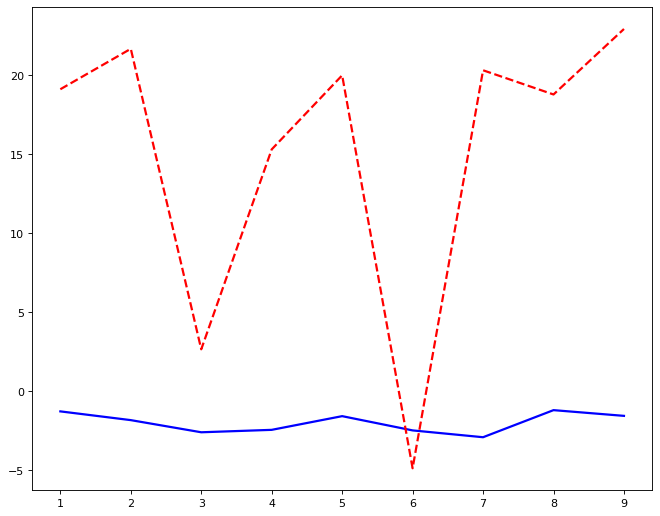

In [14]:

# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

# zipped = zip(X_star, y_star, y_pred)
# sort_zipped=sorted(zipped,key=lambda x:(x[0],x[1],x[2]))
# result=zip(*sort_zipped)
# X_star, y_star, y_pred=[list(x) for x in result]
# X_star=(np.array(X_star).reshape(-1)).tolist()
# y_star=(np.array(y_star).reshape(-1)).tolist()
# y_pred=(np.array(y_pred).reshape(-1)).tolist()

# print(X_star, y_star, y_pred)
index=[1,2,3,4,5,6,7,8,9]
y_pred=np.array(y_pred)
y_star=np.array(y_star)

print("r2 socre:",r2_score(y_star,y_pred))

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var[:,None]))
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
# ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
